Notebook that records and plots the feedback that the first layer of the MLP network receives when it is trained in isolation (cfr. section A.1 in the Supplementary Material of the paper).

In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

%load_ext autoreload

In [2]:
%autoreload
import sys
sys.path.insert(0, "../")

import warnings

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

from sklearn import metrics

from mnist_experiment_utils import load_data, get_model
from experiment_utils import plot_history

from keras.optimizers import SGD

from training_memory import LayerFeedbackMemory, LayerInputMemory

/home/sicarbonnell/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train loss: 0.2648245167732239
Train accuracy: 1.0
Test loss: 1.1391402854919435
Test accuracy: 0.7188


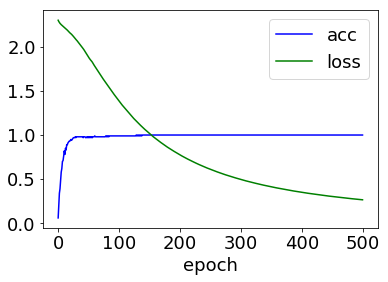

In [43]:
experiment = 0
x_train, y_train, x_test, y_test = load_data(experiment)
model = get_model(experiment)

# parameters for recording of the gradients during training
batch_frequency = 1 # once per epoch since all data goes into one batch
nb_samples_stored = 5000
nb_neurons_stored = np.inf
sample_indices = np.random.choice(x_test.shape[0],min(x_test.shape[0],nb_samples_stored)) # test samples!
neuron_indices = np.random.choice(784,min(784,nb_neurons_stored))


lr = 1
batch_size = 128
epochs = 500
verbose = 0

layer = 'dense0'

for l in model.layers:
    if l.name != layer:
        l.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr),
              metrics=['accuracy'])

# inputs of the layer were also stored during experiments, but this is not presented in our paper. Should be ignored.
inputstore = LayerInputMemory(model.get_layer(layer), model, 
                           x_test,
                           sample_indices,
                           neuron_indices,
                           batch_frequency = batch_frequency,
                           epoch_stop = 0)

feedbackstore = LayerFeedbackMemory(model.get_layer(layer), model, 
                           x_test,
                           y_test, 
                           sample_indices,
                           neuron_indices,
                           batch_frequency = batch_frequency)

warnings.filterwarnings("ignore") # to remove Keras' warning for slow callback

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    callbacks = [inputstore, feedbackstore])

score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

score_test = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

plot_history(history)

inputs = np.array(inputstore.activations_accumulator)
feedbacks = np.array(feedbackstore.gradients_accumulator)

In [56]:
signal = inputs
m = []
for i in range(signal.shape[0]):
    m.append(metrics.silhouette_score(signal[i], np.where(y_test[sample_indices])[1], metric='cosine'))

with open(layer+'_input_silhouette.p','wb') as f:
    pickle.dump(m,f)
    
signal = feedbacks
m = []
for i in range(signal.shape[0]):
    m.append(metrics.silhouette_score(signal[i], np.where(y_test[sample_indices])[1], metric='cosine'))

with open(layer+'_feedback_silhouette.p','wb') as f:
    pickle.dump(m,f)

[0.10694491504048319]


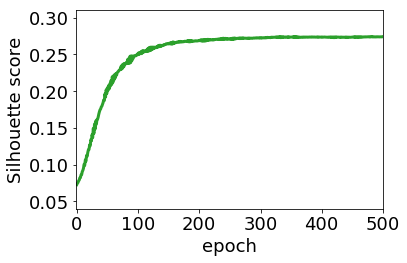

In [3]:
%matplotlib inline
with open('dense0_feedback_silhouette.p','rb') as f:
    m = pickle.load(f)

matplotlib.rcParams.update({'font.size': 18})

plt.plot(range(len(m)),m,linewidth=3.0, color = 'C2')
plt.xlabel('epoch')
plt.ylabel('Silhouette score')
plt.ylim(0.04,0.31)
plt.xlim(-0.5,500)
plt.xticks([0,100,200,300,400,500])
plt.yticks([0.05,0.1,0.15,0.2,0.25,0.3])

plt.tight_layout()

# plt.savefig('figures/MNIST_feedbackAnalysis.eps',format='eps', dpi=200)
# plt.savefig('figures/MNIST_feedbackAnalysis.png',format='png', dpi=300)